#Notebook for testing performance of Visaul Recognition Custom Classifiers
[Watson Developer Cloud](https://www.ibm.com/watsondevelopercloud) is a platform of cognitive services that leverage machine learning techniques to help partners and clients solve a variety of business problems. Furthermore, several of the WDC services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of your solution. For more details on these various metrics, please consult the **[Is Your Chatbot Ready for Prime-Time?](https://developer.ibm.com/dwblog/2016/chatbot-cognitive-performance-metrics-accuracy-precision-recall-confusion-matrix/)** blog.


<br> The notebook assumes you have already created a Watson [Visual Recognition](https://www.ibm.com/watson/developercloud/visual-recognition.html) instance and trained [custom classifiers](https://www.ibm.com/watson/developercloud/doc/visual-recognition/tutorial-custom-classifier.html). </br>
<br> To leverage this notebook, you need to provide the following information</br>
* Credentials for your Visual Recognition instance (apikey)
* id for your trained classifier (this is returned when you train your Visual Recognition custom classifier)
* csv file with your test images (paths to images on your local disk) and corresponding class labels
* results csv file to write the results to (true vs. predicted class labels)
* csv file to write confusion matrix to

Note that the input test csv file should have a header with the fields **image** and **class**. 

In [1]:
!pip install matplotlib

In [1]:
#Import utilities
import json
import csv
import sys
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas_ml
import cv2
import numpy as np
import time 
import requests
import operator
from __future__ import print_function
import json
import csv
from pandas_ml import ConfusionMatrix
from watson_developer_cloud import VisualRecognitionV3
import itertools

%matplotlib inline 

Provide the path to the parms file which includes credentials to access your VR service as well as the input
test csv file and the output csv files to write the output results to.

In [2]:
# Provide complete path to the file which includes all required parms
# A sample parms file is included (example_VR_parms.json)
vrParmsFile = '/Users/lkrishna/git/wdcutils/example_VR_parms.json'
parms = ''
with open(vrParmsFile) as parmFile:
    parms = json.load(parmFile)

url=parms['url']
apikey=parms['apikey']
vr_id=parms['vr_id']
test_csv_file=parms['test_csv_file']
results_csv_file=parms['results_csv_file']
confmatrix_csv_file=parms['confmatrix_csv_file']
json.dumps(parms)

# Create an object for your Visual Recognition instance
visual_recognition = VisualRecognitionV3('2016-05-20', api_key=apikey)

Define useful methods to classify using custom VR classifier.

In [21]:
# Given an image and a pointer to VR instance and classifierID, get back VR response
def getVRresponse(vr_instance,classifierID,image_path):
    with open(image_path, 'rb') as image_file:
        parameters = json.dumps({'threshold':0.01, 'classifier_ids': [classifierID]})
       #parameters = json.dumps({'threshold':0.01, 'classifier_ids': ['travel_1977348895','travel_2076475268','default']}) 
        image_results = vr_instance.classify(images_file=image_file,
                                             parameters = parameters)
        # For our purposes, we assume each call is to classify one image
        # Although the Visual Recognition classify endpoint accepts as input
        # a .zip file, we need each image to be labeled with the correct class
        classList = []
        for classifier in image_results['images'][0]['classifiers']:
            if classifier['classifier_id'] == vr_id:
                classList = classifier['classes']
                break
        # Sort the returned classes by score
        #print("classList: ", classList)
        sorted_classList = sorted(classList, key=lambda k: k.get('score', 0), reverse=True)
        #print("sortedList: ", sorted_classList)
    return sorted_classList

# Process multiple images (provided via csv file) in batch. Effectively, read the csv file and for each image
# get VR response. Aggregate and return results.
def batchVR(vr_instance,classifierID,csvfile):
    test_classes=[]
    vr_predict_classes=[]
    vr_predict_confidence=[]
    images=[]
    i=0
    with open(csvfile, 'r') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            vr_response = getVRresponse(vr_instance,classifierID,row['image'])
            vr_predict_classes.append(vr_response[0]['class'])
            vr_predict_confidence.append(vr_response[0]['score'])
            images.append(row['image'])
            i = i+1
            if(i%5 == 0):
                print("")
                print("Processed ", i, " images")
            if(i%10 == 0):
                sys.stdout.write('.')
        print("")
        print("Finished processing ", i, " images")
    return test_classes, vr_predict_classes, vr_predict_confidence, images

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()
    

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'w') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            
# get maximum score
def getMaxConfidenceClass(classes):
    scores = []
    maxClass = ''
    for clazz in classes:
        scores.append(clazz['score'])
    maxConfidence = numpy.amax(scores)
    for clazz in classes:
        if clazz['score'] == maxConfidence:
           maxClass = clazz['class']
           return maxClass,maxConfidence
        
# Returns precision, recall, F1 in DataFrame format     
def getPrecisionRecallF1Support(test_classes, predict_classes,_labels):
    clf_rep = precision_recall_fscore_support(test_classes, predict_classes,labels=_labels)
    out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
    out_df = pd.DataFrame(out_dict,index=labels)
    avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
    avg_tot.index = ["avg/total"]
    out_df = out_df.append(avg_tot)
    return out_df

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
            

In [27]:
# This is an optional step to quickly test response from Visual Recognition for a given image
testImage='/Users/lkrishna/Downloads/connectors/test-set/IMG_0127.jpg'
results = getVRresponse(visual_recognition,vr_id,testImage)
print(json.dumps(results[:3], indent=2))

[
  {
    "class": "usbc_female",
    "score": 0.989555
  },
  {
    "class": "hdmi_male",
    "score": 0.874156
  },
  {
    "class": "usbc_male",
    "score": 0.827323
  }
]


Call Visual Recognition on the specified csv file and collect results.

In [9]:
test_classes,vr_predict_classes,vr_predict_conf,images=batchVR(visual_recognition,vr_id,test_csv_file)


Processed  5  images

Processed  10  images
.
Finished processing  10  images


In [18]:
# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by NLC.
csvfileOut=results_csv_file
with open(csvfileOut, 'w') as csvOut:
    outrow=['image','true class','VR Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(images)):
        outrow=[images[i],test_classes[i],vr_predict_classes[i],str(vr_predict_conf[i])]
        csvWriter.writerow(outrow)

In [19]:
# Compute confusion matrix
labels=list(set(test_classes))
vr_confusion_matrix = confusion_matrix(test_classes, vr_predict_classes, labels)
vrConfMatrix = ConfusionMatrix(test_classes, vr_predict_classes)

In [22]:
# Print out confusion matrix with labels to csv file
confmatrix2csv(vr_confusion_matrix,labels,confmatrix_csv_file)

Normalized confusion matrix
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   0.5  0.5]
 [ 0.   0.   0.   1. ]]


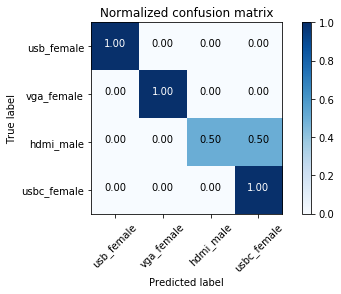

In [23]:
%matplotlib inline
#vrConfMatrix.plot()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(vr_confusion_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [25]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, vr_predict_classes)
print('Classification Accuracy: ', acc)

Classification Accuracy:  0.9


In [26]:
# print precision, recall and f1-scores for the different classes
print (getPrecisionRecallF1Support(test_classes, vr_predict_classes, labels))

             f1-score  precision  recall  support
usb_female       1.00       1.00    1.00      2.0
vga_female       1.00       1.00    1.00      4.0
hdmi_male        0.67       1.00    0.50      2.0
usbc_female      0.80       0.67    1.00      2.0
avg/total        0.87       0.92    0.88     10.0


In [ ]:
#Optional if you would like each of these metrics separately
#[precision,recall,fscore,support]=precision_recall_fscore_support(test_classes, vr_predict_classes, labels=labels)
#print "precision: ", precision
#print "recall: ", recall
#print "f1 score: ", fscore
#rint "support: ", support